** Objectives **

* How to load a large file into memory using Pandas ?

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os, sys

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

basepath = os.path.expanduser('~/Desktop/src/Loan_Default_Prediction/')
sys.path.append(os.path.join(basepath, 'src'))

In [2]:
# load files
chunksize = 10 ** 4

train_chunks = pd.read_table(os.path.join(basepath, 'data/raw/train_v2.csv'), \
                             chunksize=chunksize, \
                             sep=',', \
                             index_col='id'
                            )
test_chunks  = pd.read_csv(os.path.join(basepath, 'data/raw/test_v2.csv'), \
                           chunksize=chunksize,\
                           sep=',', \
                           index_col='id'
                          )

In [3]:
train = pd.concat(train_chunks)

In [4]:
test  = pd.concat(test_chunks)

In [10]:
def unique_values(df, features):
    return {feature: df[feature].nunique() for feature in features}

def get_features_std(df):
    # select numerical features
    numerical_columns = df.select_dtypes(exclude=['object']).columns
    
    return {col:df[col].std() for col in numerical_columns}
        

def get_features_with_single_val(feature_dict):
    return [k for k, v in feature_dict.items() if v == 1]

In [6]:
features = test.columns

feature_dict_train = unique_values(train, features)
feature_dict_test  = unique_values(test, features)

In [7]:
features_with_single_val_train = get_features_with_single_val(feature_dict_train)
features_with_single_val_test  = get_features_with_single_val(feature_dict_test)

In [11]:
features_std_train = get_features_std(train)
features_std_test  = get_features_std(test)

** Features in training set which take a single value. **

In [8]:
print(features_with_single_val_train)

['f33', 'f678', 'f37', 'f764', 'f700', 'f34', 'f38', 'f702', 'f701', 'f736', 'f35']


** Features in test set which take a single value. **

In [9]:
print(features_with_single_val_test)

['f33', 'f678', 'f37', 'f764', 'f700', 'f34', 'f38', 'f702', 'f701', 'f736', 'f35']


** Features in the training set which have zero standard deviation. **

In [21]:
list(filter(lambda x: features_std_train[x] == 0, features_std_train.keys()))

['f33',
 'f678',
 'f37',
 'f700',
 'f764',
 'f34',
 'f38',
 'f702',
 'f701',
 'f736',
 'f35']

** Features in the training set which have zero standard deviation. **

In [22]:
list(filter(lambda x: features_std_test[x] == 0, features_std_test.keys()))

['f33',
 'f678',
 'f37',
 'f700',
 'f764',
 'f34',
 'f38',
 'f702',
 'f701',
 'f736',
 'f35']

** Class Imbalance **

In [11]:
train.loss.value_counts()

0      95688
2       1297
1       1145
3       1086
4       1038
5        685
6        573
7        565
8        487
10       316
9        312
11       234
12       211
13       188
14       157
15       140
16       129
17       123
18       100
20        83
21        76
19        73
22        72
23        48
24        48
27        46
25        45
100       35
28        35
29        33
       ...  
42         4
84         4
62         4
94         4
60         3
78         3
90         3
58         3
53         3
74         2
57         2
56         2
65         2
70         2
68         1
55         1
52         1
81         1
71         1
72         1
83         1
73         1
99         1
95         1
76         1
92         1
77         1
85         1
80         1
63         1
Name: loss, dtype: int64

** Distribution for different instances. **

In [14]:
len(train)

105471

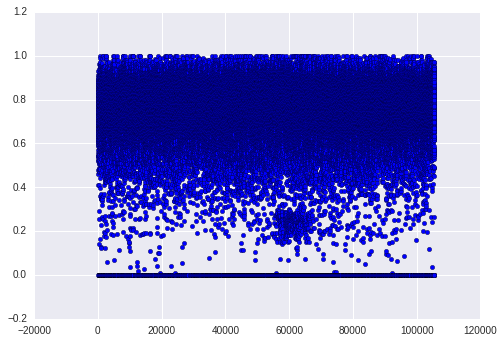

In [13]:
plt.scatter(np.arange(len(train)), train['f14']);

** Histogram of features ( training set ). **

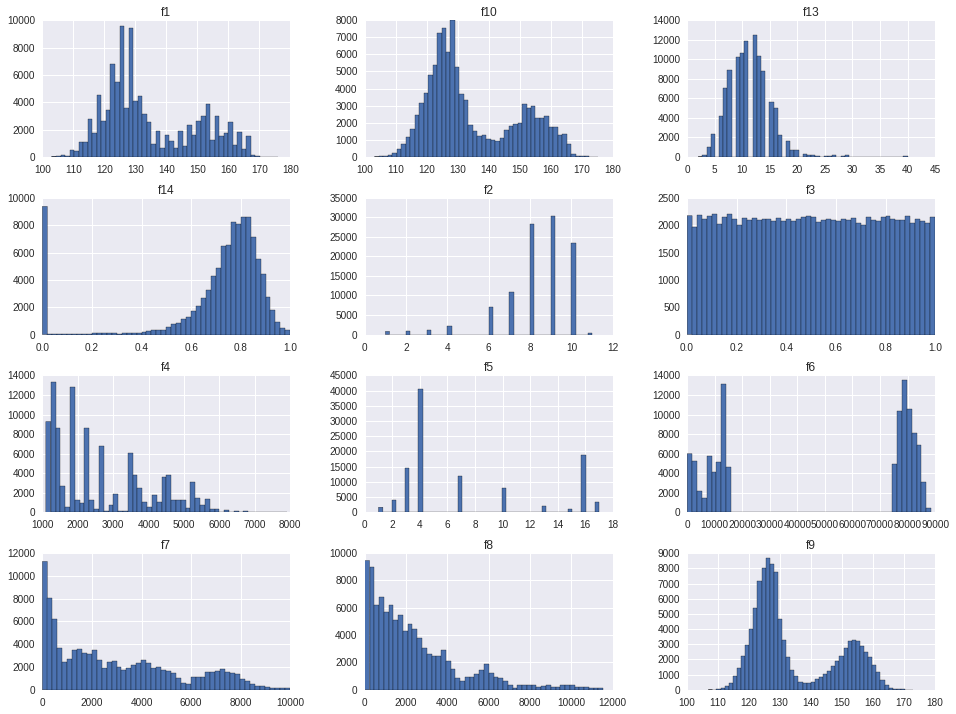

In [36]:
train.ix[:, :12].hist(figsize=(16, 12), bins=50);

** Histogram of features ( test set ) **

In [13]:
train.columns[:12]

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f13',
       'f14'],
      dtype='object')

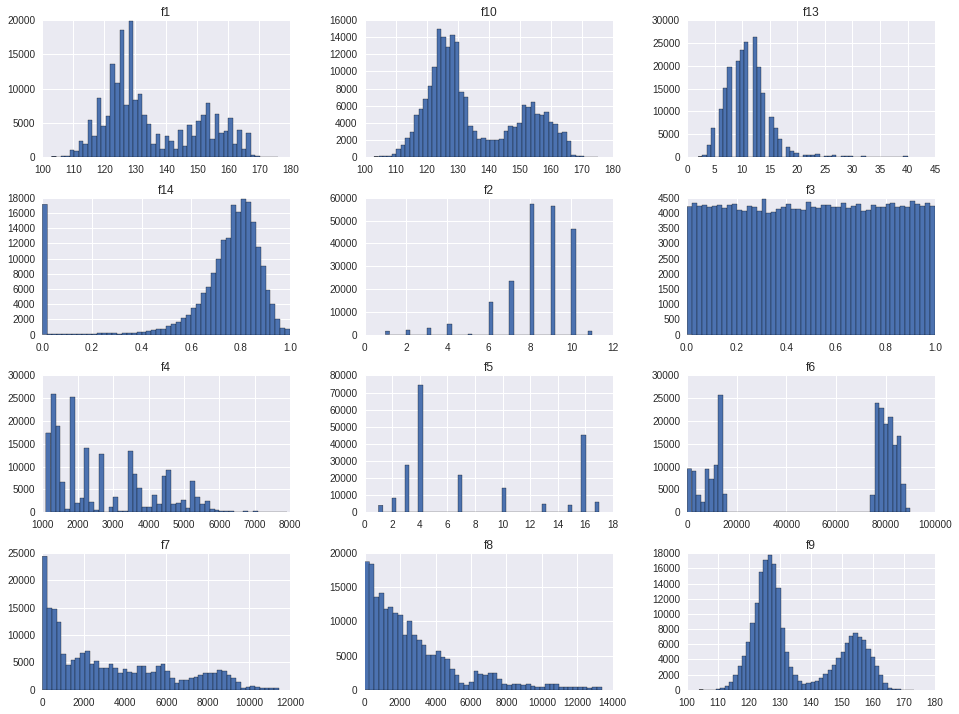

In [37]:
test.ix[:, :12].hist(figsize=(16, 12), bins=50);

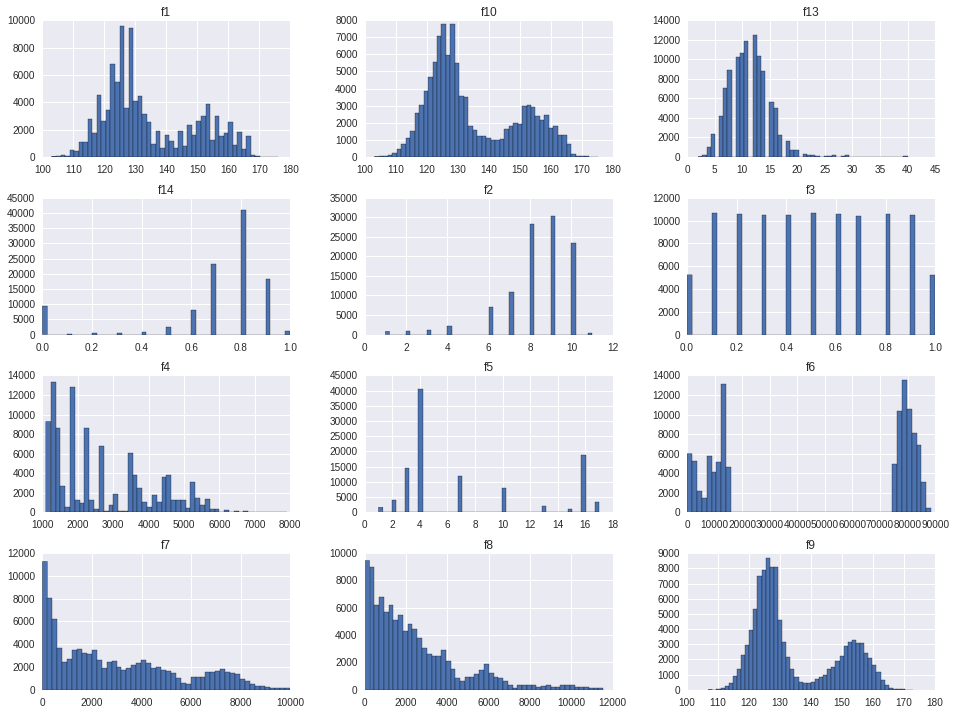

In [40]:
np.around(train.ix[:, :12], decimals=1).hist(figsize=(16, 12), bins=50);

In [15]:
class FeatureExtractor:
    def __init__(self, train, test):
        self.train = train
        self.test  = test
    
    def extract(self):
        self.round_values()
        self.create_features()
        
        return self.get_train(), self.get_test()
    
    def round_values(self):
        self.train = np.around(self.train, decimals=1)
        self.test  = np.around(self.test, decimals=1)
    
    def create_features(self):
        # feature based out of f1
        self.train['f1_cat'] = (self.train['f1'] < 140).astype(np.int)
        self.test['f1_cat']  = (self.test['f1'] < 140).astype(np.int)
        
        # feature based out of f9
        self.train['f9_cat'] = (self.train['f9'] < 140).astype(np.int)
        self.test['f9_cat']  = (self.test['f9'] < 140).astype(np.int)
        
        # feature based out of 10
        self.train['f10_cat'] = (self.train['f10'] < 140).astype(np.int)
        self.test['f10_cat']  = (self.test['f10'] < 140).astype(np.int)
        
        # feature out of f14
        self.train['f14_cat'] = (self.train['f14'] == 0.0).astype(np.int)
        self.test['f14_cat']  = (self.test['f14'] == 0.0).astype(np.int)
        
        # feature out of f6
        self.train['f6_cat'] = (self.train['f6'] < 2e4).astype(np.int)
        self.test['f6_cat']  = (self.test['f6'] < 2e4).astype(np.int)
         
    def get_train(self):
        return self.train
    
    def get_test(self):
        return self.test

In [16]:
feat = FeatureExtractor(train[train.columns[:12]], test[test.columns[:12]])
train_sub, test_sub = feat.extract()

In [20]:
train_sub.to_csv(os.path.join(basepath, 'data/processed/train_sub.csv'), index=False)
test_sub.to_csv(os.path.join(basepath, 'data/processed/test_sub.csv'), index=False)

train[['loss']].to_csv(os.path.join(basepath, 'data/processed/target.csv'), index=False)